In [1]:
import matplotlib.pylab as plt
import folium
import geopandas as gpd
import pyproj as pp
import shapely as shp
import numpy as np
import os
import urllib.request
import pandas as pd


crsCABA = """
PROJCS["CABA-PG07",
GEOGCS["GCS_WGS_1984",
DATUM["D_WGS_1984",
SPHEROID["WGS_1984",6378137.0,298.257223563]],
PRIMEM["Greenwich",0.0],
UNIT["Degree",0.0174532925199433]],
PROJECTION["Transverse_Mercator"],
PARAMETER["False_Easting",20000.0],
PARAMETER["False_Northing",70000.0],
PARAMETER["Central_Meridian",-58.4633083333333],
PARAMETER["Scale_Factor",1.0],
PARAMETER["Latitude_Of_Origin",-34.6292666666667],
UNIT["Meter",1.0]]
"""

# Los datos
Los datos con los que trabajamos son extraídos directamente de las páginas oficiales del gobierno de la Ciudad de Buenos Aires. Esto permite que no tengamos que trabajar con archivos ya descargados.

In [2]:
d_bp = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-desarrollo-humano-y-habitat/barrios-populares/barrios-populares-badata.zip') # Barrios populares
d_b = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.zip') # Barrios de CABA
d_c = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/jefatura-de-gabinete-de-ministros/calles/callejero.zip') # Calles de CABA
urls_transporte = ['https://datos.transporte.gob.ar/dataset/f87b93d4-ade2-44fc-a409-d3736ba9f3ba/resource/5ab88c4b-b8b0-4f3b-a840-52e0e83e96ab/download/lineas-nacionales.zip', # Colectivos nacionales
                   'https://datos.transporte.gob.ar/dataset/f87b93d4-ade2-44fc-a409-d3736ba9f3ba/resource/6dab78ec-d512-4fc4-a5e8-f97a1826ba2f/download/lineas-provinciales.zip', # Colectivos provinciales (PBA)
                   'https://datos.transporte.gob.ar/dataset/f87b93d4-ade2-44fc-a409-d3736ba9f3ba/resource/d5b82e09-2844-4adf-8e88-8f20904a7af0/download/lineas-municipales.zip', # Colectivos municipales (PBA)
                   'https://datos.transporte.gob.ar/dataset/f87b93d4-ade2-44fc-a409-d3736ba9f3ba/resource/5dd356b0-624c-4ea8-9315-b1c0a389b245/download/subterraneo-lineas.zip', # Subte CABA
                   'https://datos.transporte.gob.ar/dataset/f87b93d4-ade2-44fc-a409-d3736ba9f3ba/resource/87fb1c41-89b5-42db-b45a-992672931b2d/download/rmba-ferrocarril-lineas.zip', # Trenes AMBA
                   ]
[urllib.request.urlretrieve(u, u.split('/')[-1]) for u in urls_transporte] # Descargamos los archivos de transporte, a diferencia de los otros que los abrimos directo
d_ts = [gpd.read_file(u.split('/')[-1]) for u in urls_transporte] # Abrimos los archivos de transporte
for d,modo in zip(d_ts, ['colectivo','colectivo','colectivo','subte','tren']): # Iteramos sobre cada data frame para homologar algunas columnas
    d.loc[:,'modo'] = modo
    d.rename({'Linea':'LINEA'}, axis = 1, inplace = True)
    d.rename({'LINEASUB':'LINEA'}, axis = 1, inplace = True)

d_t = gpd.pd.concat(d_ts) # Juntamos todos los data frames de transporte
d_bp.to_crs(d_b.crs, inplace = True) # Llevamos todos los data frames a la misma proyección, la de los barrios
d_c.to_crs(d_b.crs, inplace = True)
d_t.to_crs(d_b.crs, inplace = True)



# El primer análisis
Podemos elegir algún barrio popular para filtrar sus polígonos (pensar que cada barrio suele estar particionado en manzanas y demás) y:
* quedarnos con los barrios que lo contienen
* con las calles contenidas en esos barrios
* y con las líneas de transporte que intersecan con una simplificación del polígono del barrio popular

In [3]:
barrios_populares = ['Mugica']
d_bp_aux = [d_bp[(d_bp.ALIAS.str.contains(bp, regex = True, na = False))].copy() for bp in barrios_populares]
d_b_aux = d_b.loc[d_b.geometry.intersects(shp.ops.unary_union(np.concatenate([d.geometry.values for d in d_bp_aux]))),:].copy()
d_c_aux = d_c.loc[d_c.geometry.within(shp.ops.unary_union(d_b_aux.geometry)),:].copy()
d_t_aux = gpd.pd.concat([d_t.loc[d_t.geometry.intersects(shp.ops.unary_union(d.geometry).minimum_rotated_rectangle),:].copy() for d in d_bp_aux])


Una vez que hacemos esto, podemos visualizar los resultados, decidimos en este caso no mostrar el transporte público porque queda muy saturada la visualización.

En este análisis, podemos mostrar más de un barrio a la vez

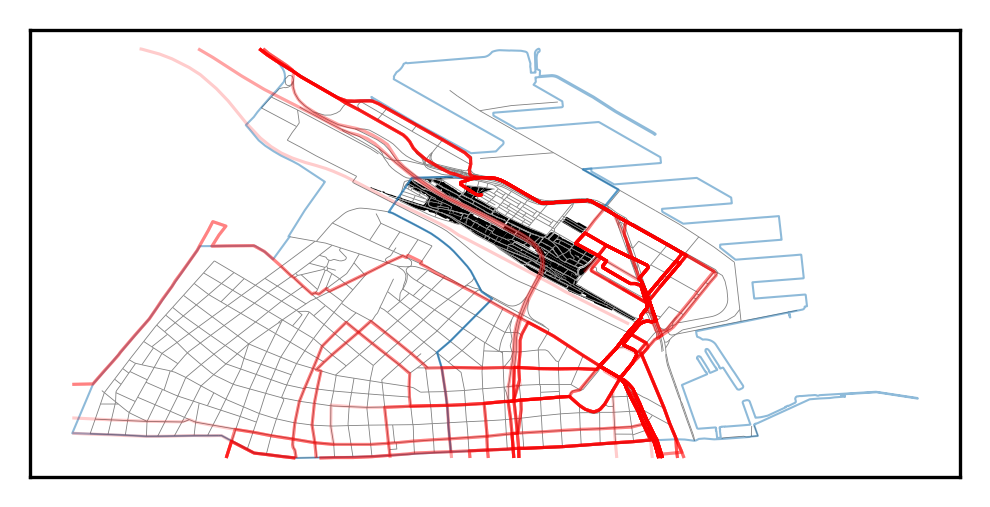

In [4]:
fig, ax = plt.subplots(figsize = (4, 4 * (np.diff(shp.ops.unary_union(d_b_aux.geometry).envelope.bounds[1::2]) / np.diff(shp.ops.unary_union(d_b_aux.geometry).envelope.bounds[::2]))[0]),dpi = 300)
d_c_aux.plot(ax = ax, lw = 0.2, color = 'grey')
d_b_aux.boundary.plot(alpha = 0.5, lw = 0.5, ax = ax)
for d in d_bp_aux:
    d.plot(ax = ax, color = 'k')
xmin, ymin, xmax, ymax = d_b_aux.total_bounds

d_t_aux.geometry.apply(lambda x: x.intersection(shp.geometry.box(xmin, ymin, xmax,ymax))).plot(ax = ax, color = 'red', alpha = 0.2, lw = .75)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(linestyle = 'dashed', lw = 0.2)
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Ahora, podemos ver esto mismo pero en un mapa dinámico, incorporando la capa de transporte público. Por colores, quedan diferenciados los distintos modos de transporte.

In [5]:
barrios_populares = ['Mugica', ]
d_bp_aux = [d_bp[(d_bp.ALIAS.str.contains(bp, regex = True, na = False))].copy() for bp in barrios_populares]
d_b_aux = d_b.loc[d_b.geometry.intersects(shp.ops.unary_union(np.concatenate([d.geometry.values for d in d_bp_aux]))),:].copy()
d_c_aux = d_c.loc[d_c.geometry.within(shp.ops.unary_union(d_b_aux.geometry)),:].copy()
d_t_aux = gpd.pd.concat([d_t.loc[d_t.geometry.intersects(shp.ops.unary_union(d.geometry).minimum_rotated_rectangle),:].copy() for d in d_bp_aux])


In [6]:
xy_inicial = list(shp.ops.unary_union(gpd.pd.concat(d_bp_aux).geometry).centroid.coords)[0][::-1]

color_dict = {'colectivo' : '#40b30e',
              'subte' : '#d6e62e',
              'tren' : '#2ba5d9'}
hcolor_dict = {'colectivo' : '#58fa11',
              'subte' : '#ebfc32',
              'tren' : '#32c0fc'}

highlight_style = lambda feature: {
                                   "color": hcolor_dict[feature['properties']['modo']],
                                   "opacity" : 1,
                                   "weight": 5,
                                   }

style_t = lambda feature: {'color' : color_dict[feature['properties']['modo']],
                            "weight": 5,
                            "opacity": .5,
                            }

style_b = lambda feature: {
                            "fillColor": "#34c0eb",
                            "color": "black",
                            "weight": .75,
                            "dashArray": "5, 5",
                            "fillOpacity": 0.3,
                            }

style_bp = lambda feature: {
                            "fillColor": "#eb9834",
                            "color": "black",
                            "weight": .25,
                            "fillOpacity": 0.8,
                            }
style_envbp = lambda feature: {
                            "fillColor": "#eb9834",
                            "color": "black",
                            "weight": .45,
                            "fillOpacity": 0.4,
                            }

f = folium.Figure(width = "60%")
map = folium.Map(location = xy_inicial,
                 zoom_start = 16,
                 min_zoom = 11,
                 max_bounds = True
                 )
popup_t = folium.GeoJsonPopup(['LINEA'])
capa_t = folium.GeoJson(d_t_aux.to_json(), popup = popup_t, name = 'Transporte', style_function=style_t, highlight_function=highlight_style, popup_keep_highlighted=True)
map.add_child(capa_t)

popup_b = folium.GeoJsonPopup(['nombre', 'comuna'])
capa_b = folium.GeoJson(d_b_aux.to_json(), name = 'Barrios', zoom_on_click = True, popup = popup_b,show = False, style_function=style_b)
map.add_child(capa_b)


popup_bp = folium.GeoJsonPopup(['NOMBRE', 'TIPO_ASENT', 'MANZANA', 'OBSERV',])
capa_bp = folium.GeoJson(gpd.pd.concat(d_bp_aux).to_json(),
                         name = 'Barrios populares',
                         zoom_on_click=True,
                         popup = popup_bp,
                         style_function=style_bp)
map.add_child(capa_bp)

capa_polbp = folium.GeoJson(gpd.GeoSeries([shp.ops.unary_union(d.geometry).minimum_rotated_rectangle for d in d_bp_aux]).reset_index().to_json(),
                            show = False,
                            control = True,
                            style_function=style_envbp,
                            name = 'Envolvente BP'
                            )
map.add_child(capa_polbp)

map.keep_in_front( capa_t, capa_b, capa_bp, capa_polbp)
folium.LayerControl().add_to(map)

f.add_child(map)
f

# Segundo análisis: ¿a dónde llegamos desde cada barrio?
La idea es analizar hasta dónde se puede llegar tomando un sólo transporte desde un barrio popular.

## Superficie cubierta
El primer abordaje consiste en ver qué porcentaje de CABA queda cubierto por las líneas que pasan por cierto barrio popular y qué porcentaje queda sin cubrir. Para esto, ya que el transporte es una "línea", debemos expandir estos objetos para que se vuelvan algo de medida no nula. Por ejemplo, tomamos $150\ mts$, emulando que caminar una cuadra y media para un lado o para el otro de donde pasa un transporte es bastante accesible.

In [7]:
d_t_auxRP = d_t_aux.to_crs(crsCABA).copy()
d_c_RP = d_c_aux.to_crs(crsCABA).copy()
d_b_RP = d_b.to_crs(crsCABA).copy()

d_t_Buffered = d_t_auxRP.copy()
buffer = 150
d_t_Buffered.loc[:,"geometry"] = d_t_Buffered.loc[:,"geometry"].buffer(buffer)


In [8]:
ciudad = shp.ops.unary_union(d_b_RP.geometry)
transporte = shp.union_all(d_t_Buffered.geometry)
transporte_caba = transporte.intersection(ciudad)
ciudad_NoCubierta = shp.difference(ciudad, transporte_caba)

d_AUX_BP_CRS = gpd.GeoSeries([shp.ops.unary_union(d.geometry).minimum_rotated_rectangle for d in d_bp_aux],).reset_index()
d_AUX_BP_CRS.crs = d_bp.crs
d_AUX_BP_CRS = d_AUX_BP_CRS.to_crs(crsCABA)

In [9]:
area_cubierta = transporte_caba.area / ciudad.area
area_descubiertaMasGrande = sorted([g for g in ciudad_NoCubierta.geoms], key = lambda x: x.area, reverse = True)[0].area / ciudad.area
print(f'El área alcanzada con un único transporte público, tomando un buffer de {buffer} metros es un {round(area_cubierta, 3)} del área total de CABA.\nLa superficie máxima sin cobertura representa en cambio un {round(area_descubiertaMasGrande, 3)} del total.')

El área alcanzada con un único transporte público, tomando un buffer de 150 metros es un 0.393 del área total de CABA.
La superficie máxima sin cobertura representa en cambio un 0.217 del total.


In [10]:
areas = [g.area / ciudad.area for g in ciudad_NoCubierta.geoms]

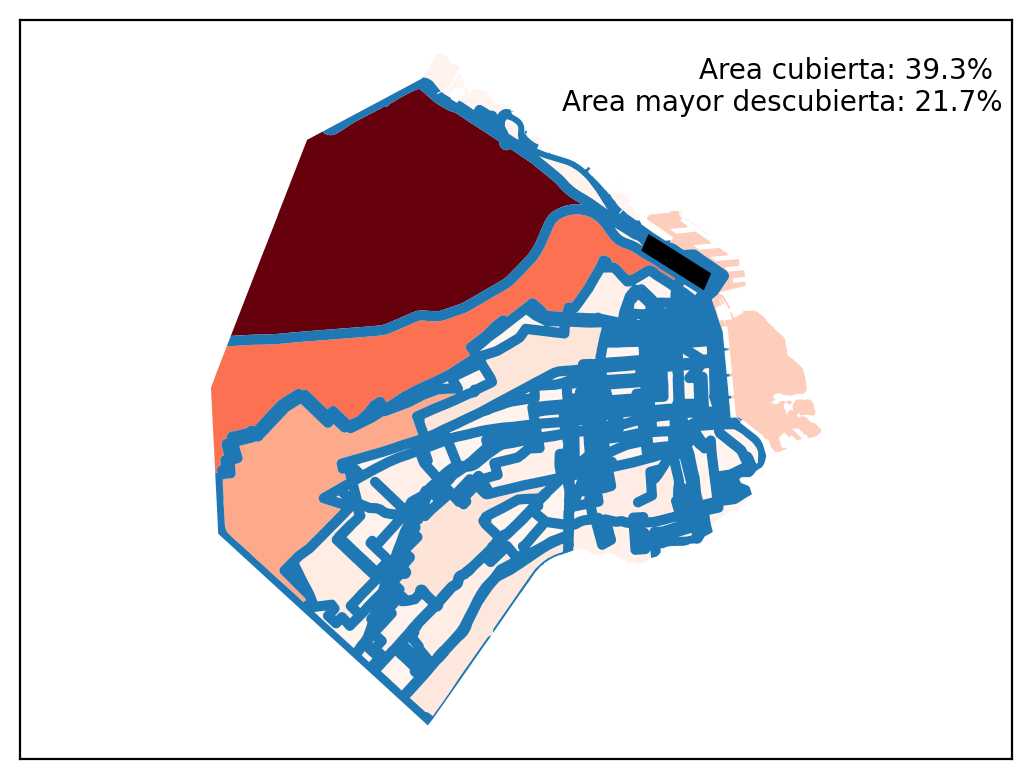

In [11]:
fig, ax = plt.subplots(dpi = 200)
gpd.GeoDataFrame([{'geometry':g, 'area':g.area} for g in ciudad_NoCubierta.geoms]).plot(ax = ax, column = 'area', cmap = 'Reds')
gpd.GeoSeries(transporte_caba).plot(ax = ax, )
d_AUX_BP_CRS.plot(ax = ax, color = 'k')
ax.text(x = .99,
        y = .95,
        s = f'Area cubierta: {round(100 * area_cubierta, 1)}% \nArea mayor descubierta: {round(100 * area_descubiertaMasGrande, 1)}%',
        transform=ax.transAxes,
        ha = 'right',
        va = 'top',)
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [12]:
d_bp_aux = [d_bp[(d_bp.NOM_MAP.str.contains(b, regex = True, na = False))].copy().geometry for b in ['Bo. Est. Buenos Aires']]
d_bp_aux

[941    POLYGON ((-58.40033 -34.64597, -58.40038 -34.6...
 Name: geometry, dtype: geometry]

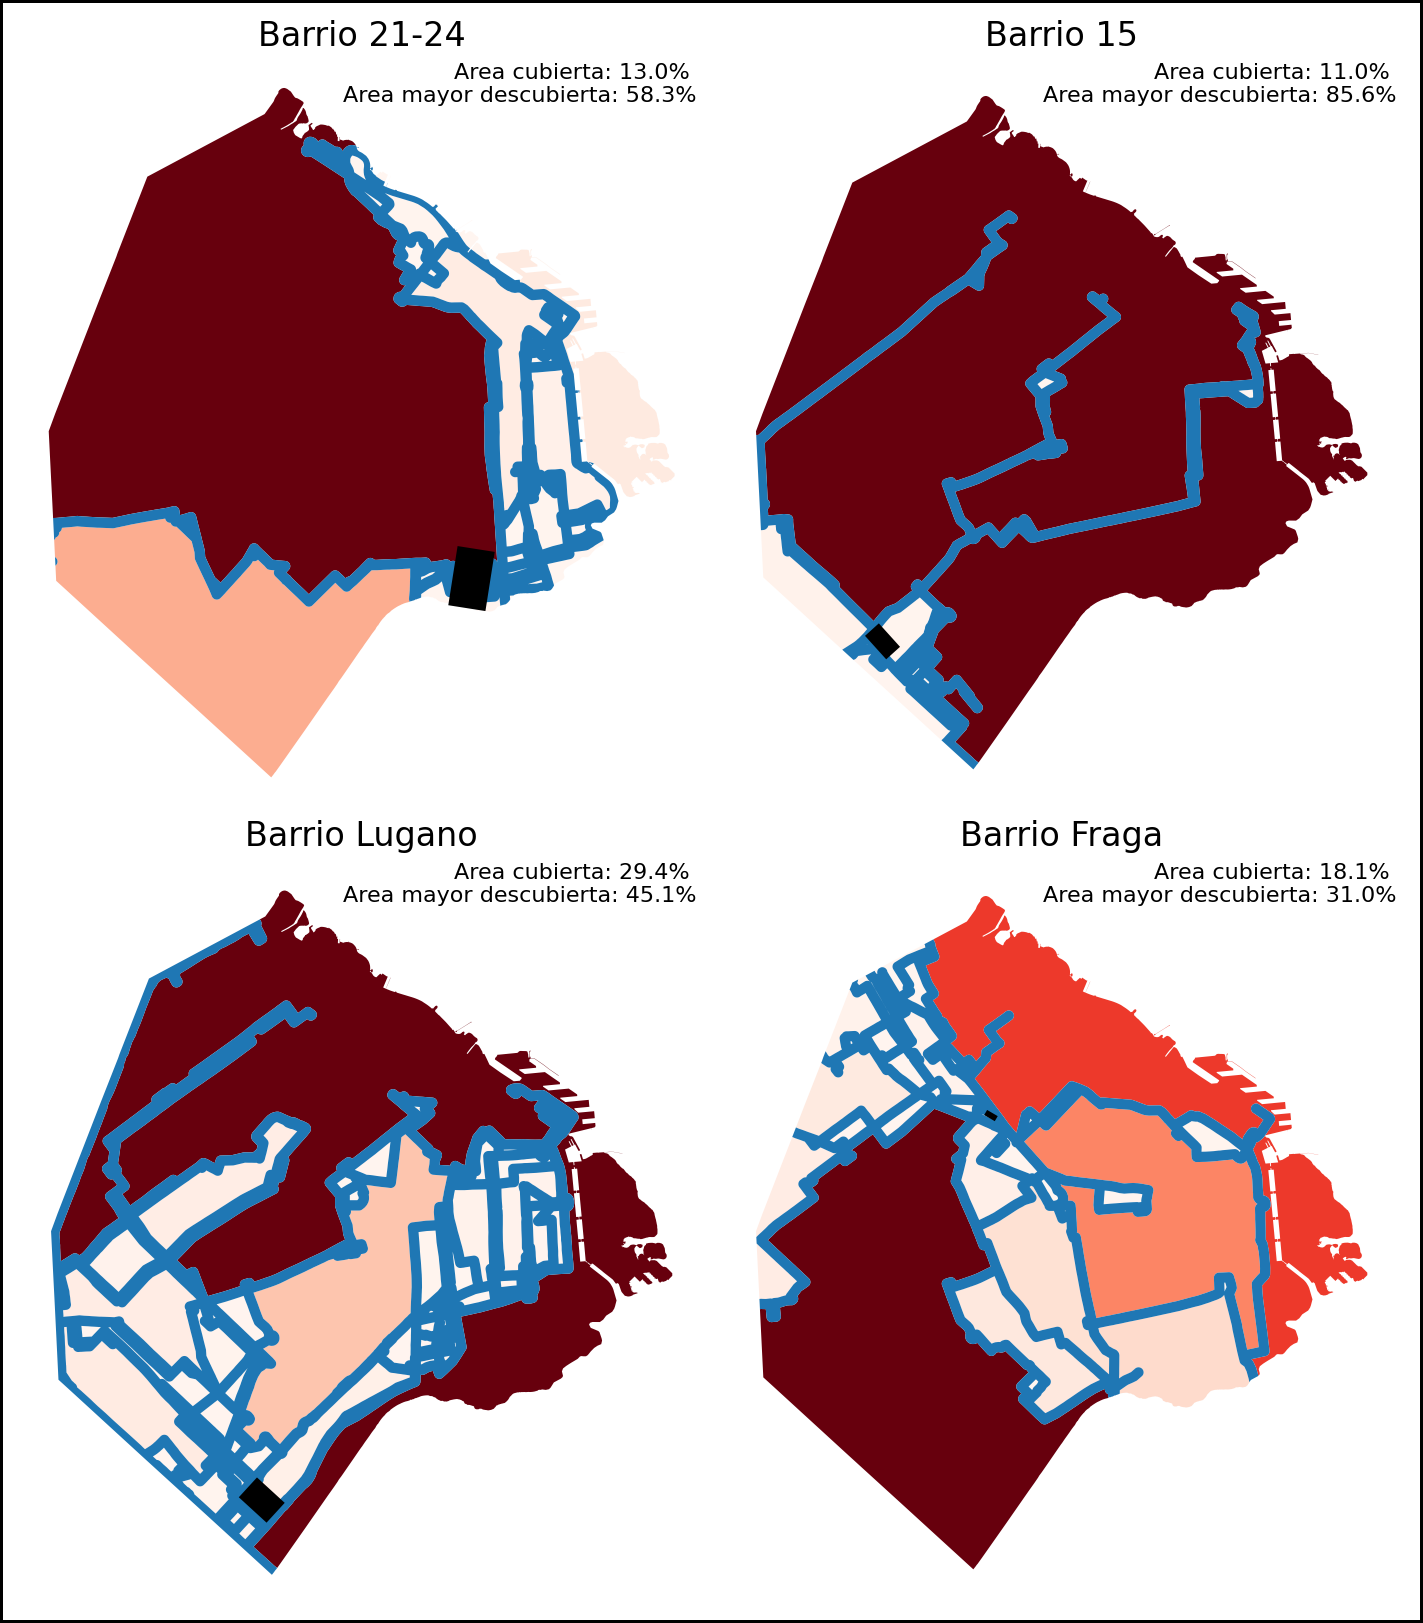

In [13]:
bp = ['21-24', 'Lugano', '15', 'Fraga']

dic_aux = {0 : (0,0), 1:(1,0),2:(0,1), 3:(1,1)}
fig = plt.figure(figsize = (7, 8), dpi = 200,constrained_layout = True)
gs = fig.add_gridspec(2, 2)
# botom_ax = fig.add_subplot(gs[2,:])

for i, b in enumerate(bp):
    if b != 'Lugano':
        d_bp_aux = [d_bp[(d_bp.ALIAS.str.contains(b, regex = True, na = False))].copy() for b in [b]]
    elif b == 'Lugano':
        d_bp_aux = [d_bp[(d_bp.NOM_MAP.str.contains(b, regex = True, na = False))].copy() for b in [b]]
    else:
        d_bp_aux = [d_bp[(d_bp.NOMBRE.str.contains(b, regex = True, na = False))].copy() for b in [b]]
    d_b_aux = d_b.loc[d_b.geometry.intersects(shp.ops.unary_union(np.concatenate([d.geometry.values for d in d_bp_aux]))),:].copy()
    d_c_aux = d_c.loc[d_c.geometry.within(shp.ops.unary_union(d_b_aux.geometry)),:].copy()
    d_t_aux = gpd.pd.concat([d_t.loc[d_t.geometry.intersects(shp.ops.unary_union(d.geometry).minimum_rotated_rectangle),:].copy() for d in d_bp_aux])

    [d.to_crs(crsCABA, inplace = True) for d in d_bp_aux]
    d_t_auxRP = d_t_aux.to_crs(crsCABA).copy()
    d_c_RP = d_c_aux.to_crs(crsCABA).copy()
    d_b_RP = d_b.to_crs(crsCABA).copy()

    d_t_Buffered = d_t_auxRP.copy()
    buffer = 150
    d_t_Buffered.loc[:,"geometry"] = d_t_Buffered.loc[:,"geometry"].buffer(buffer)

    ciudad = shp.ops.unary_union(d_b_RP.geometry)
    transporte = shp.union_all(d_t_Buffered.geometry)
    transporte_caba = transporte.intersection(ciudad)
    ciudad_NoCubierta = shp.difference(ciudad, transporte_caba)

    area_cubierta = transporte_caba.area / ciudad.area
    area_descubiertaMasGrande = sorted([g for g in ciudad_NoCubierta.geoms], key = lambda x: x.area, reverse = True)[0].area / ciudad.area

    areas = [g.area / ciudad.area for g in ciudad_NoCubierta.geoms]

    d_AUX_BP_CRS = gpd.GeoSeries([shp.ops.unary_union(d.geometry).minimum_rotated_rectangle for d in d_bp_aux],).reset_index()

    ax = fig.add_subplot(gs[dic_aux[i]])

    polBP = polBP = shp.union_all([g for d in d_bp_aux for g in d.geometry])
    gpd.GeoDataFrame([{'geometry':g, 'area':g.area} for g in ciudad_NoCubierta.geoms]).plot(column = 'area', cmap = 'Reds', ax = ax)
    gpd.GeoSeries(transporte_caba).plot(ax = ax)
    d_AUX_BP_CRS.plot(ax = ax, color = 'k')
    ax.text(x = .99,
        y = 1,
        s = f'Area cubierta: {round(100 * area_cubierta, 1)}% \nArea mayor descubierta: {round(100 * area_descubiertaMasGrande, 1)}%',
        transform=ax.transAxes,
        ha = 'right',
        va = 'top',
        fontsize = 8)
    ax.set_title(f'Barrio {b}')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('equal')
    ax.axis('off')
    # botom_ax.scatter(range(len(areas)), sorted(areas, reverse = True), label = b)
# botom_ax.legend()
# botom_ax.set_yscale('log')
# botom_ax.set_xscale('log')
fig.patch.set_linewidth(2)
fig.patch.set_edgecolor('black')
plt.show()

## Distancia al transporte
Otra forma de analizar el alcanza es poniendo atención en la distancia a vuelo de pájaro entre puntos de la ciudad y las líneas que pasan por un barrio popular. De esta forma, podemos tener más detalle.

In [14]:
try:
    import h3
except:
    !pip install h3
    import h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.1 MB/s eta 0:00:00


In [32]:
ciudad = gpd.GeoSeries(shp.ops.unary_union(d_b.geometry)).geometry[0]
ciudad_cells = h3.polygon_to_cells(h3.geo_to_h3shape(ciudad.__geo_interface__), res = 9)
ciudad_cells = gpd.GeoDataFrame([{'geometry' : shp.Point(h3.cell_to_latlng(c,)[::-1]),'cell':c } for c in ciudad_cells])
ciudad_cells.crs = 'EPSG:4326'

In [33]:
b = 'Mugica'
d_bp_aux = [d_bp[(d_bp.ALIAS.str.contains(b, regex = True, na = False))].copy() for b in [b]]
d_t_aux = gpd.pd.concat([d_t.loc[d_t.geometry.intersects(shp.ops.unary_union(d.geometry).minimum_rotated_rectangle),:].copy() for d in d_bp_aux])
d_t_auxRP = d_t_aux.to_crs(crsCABA).copy()
transporte = shp.ops.unary_union(d_t_auxRP.geometry)
transporte_caba = transporte.intersection(shp.ops.unary_union(d_b.to_crs(crsCABA).geometry))
d_t_aux_caba = gpd.GeoSeries(transporte_caba, crs = crsCABA)
d_t_aux_caba[0] = d_t_aux_caba[0].buffer(150)
d_t_aux_caba = d_t_aux_caba.to_crs('EPSG:4326')

In [50]:
ciudad_cells.to_crs(crsCABA, inplace = True)
ciudad_cells.loc[:,'distancia'] = ciudad_cells.geometry.apply(lambda x: x.distance(transporte_caba))
ciudad_cells.loc[:, 'geometry'] = ciudad_cells.cell.apply(lambda x: shp.geometry.Polygon(h3.cells_to_geo([x],)['coordinates'][0]))
ciudad_cells.crs = 'EPSG:4326'

<Axes: >

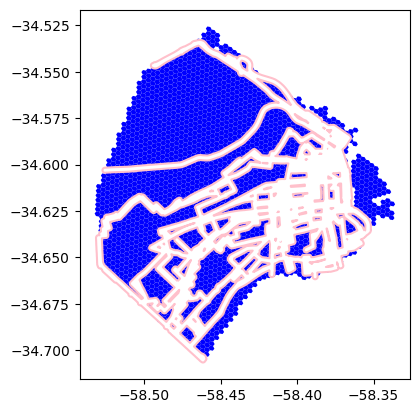

In [51]:
ax = ciudad_cells.plot(column = 'distancia', cmap = 'winter_r', vmin = 0, vmax = 5 * 10 ** 3)
d_t_aux_caba.plot(ax = ax, color = 'white')
d_t_aux_caba.boundary.plot(ax = ax, color = 'pink')

{'whiskers': [<matplotlib.lines.Line2D at 0x7b3244ed0d10>,
 'caps': [<matplotlib.lines.Line2D at 0x7b32450f5e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b32451e7950>],
 'medians': [<matplotlib.lines.Line2D at 0x7b32450f64d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b3244eb0d10>],
 'means': []}

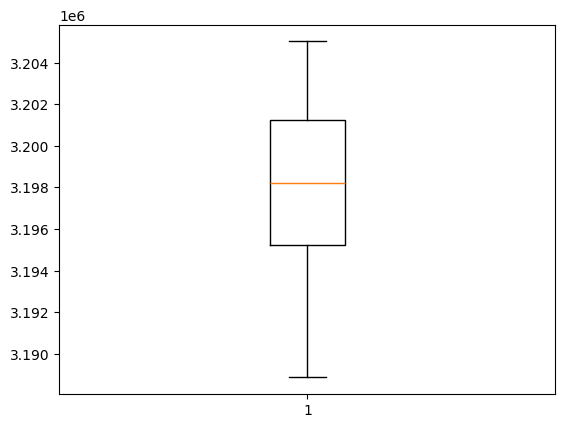

In [52]:
plt.boxplot(ciudad_cells.distancia, )

# Red de hexágonos

Armemos la red de hexágonos según su vecindad y dándole a cada hexágono un atributo en función de si contiene o no recursos culturales, educativos o de salud. Además, identificamos a los hexágonos por si pertenecen o no al barrio popular

1) ¿cuáles son las celdas que nos interesan? Las de CABA por ejemplo

2) ¿qué fecilidades tiene cada celda?

3) ¿cómo armamos la red de celdas?

In [ ]:
try:
    import h3
except:
    !pip install h3
    import h3

In [ ]:
d_bp = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-desarrollo-humano-y-habitat/barrios-populares/barrios-populares-badata.zip') # Barrios populares
d_b = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.zip')

d_bp.to_crs(d_b.crs, inplace = True)

In [ ]:
ciudad = gpd.GeoSeries(shp.ops.unary_union(d_b.geometry)).geometry[0]
#ciudad_cells = h3.polyfill(ciudad.__geo_interface__, res = 9, geo_json_conformant = True)
ciudad_cells = h3.geo_to_cells(ciudad, res = 9,)
b = 'Mugica'
d_bp_aux = [d_bp[(d_bp.ALIAS.str.contains(b, regex = True, na = False))].copy() for b in [b]]
bp = gpd.GeoSeries(shp.ops.unary_union(d_bp_aux[0].geometry)).geometry[0]
bp_cells = h3.geo_to_cells(bp.minimum_rotated_rectangle, res = 9)

In [ ]:
bp_cells = gpd.GeoDataFrame([{'geometry' : shp.Point(h3.cell_to_latlng(c,)[::-1]),
                                  'cell':c }for c in bp_cells
                                 ]
                                )
bp_cells.crs = 'EPSG:4326'

ciudad_cells = gpd.GeoDataFrame([{'geometry' : shp.Point(h3.cell_to_latlng(c,)[::-1]),
                                  'cell':c }for c in ciudad_cells
                                 ]
                                )
ciudad_cells.crs = 'EPSG:4326'

ciudad_cells.loc[ciudad_cells.cell.isin(bp_cells.cell), 'bp'] = True
ciudad_cells.loc[~ciudad_cells.cell.isin(bp_cells.cell), 'bp'] = False

In [ ]:
edges = set([(c, e) for c in ciudad_cells.cell for e in h3.grid_ring(c, 1) if e in ciudad_cells.cell.to_list()])

In [ ]:
import networkx as nx

In [ ]:
g = nx.Graph(edges)
pos = ciudad_cells.set_index('cell').geometry.apply(lambda x: x.coords[0][::]).to_dict()
nx.write_gml(g, 'celdasNet.gml')

In [ ]:
nx.draw(g,
        with_labels = False,
        pos = pos,
        node_size = 5,
        width = .5)

In [ ]:
def openURL(url):
    d = gpd.read_file(url)
    if 'geometry' not in d.columns:
        d.loc[:, 'geometry'] = [shp.geometry.Point(float(x), float(y)) for x, y in d[['long', 'lat']].values]
    d = gpd.GeoDataFrame(d, geometry = d['geometry']).copy()
    return d

urls_salud = ['https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-salud/hospitales/hospitales.geojson', # Hospitales públicos
              'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-salud/centros-salud-accion-comunitaria-cesac/centros_de_salud_nivel_1_BADATA_WGS84.geojson', # CESACs
              'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-salud/farmacias/farmacias.csv', # Farmacias
              'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-desarrollo-humano-y-habitat/centros-dia/centros-de-dia.geojson', # Centros de día
              ]

urls_educacion = ['https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/establecimientos-educativos/establecimientos_educativos_WGS84.geojson', # Escuelas pub y priv
                  'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/universidades/universidades.csv', # Universidades
                  'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-cultura/bibliotecas/bibliotecas.csv', # Bibliotecas
                  ]

urls_cultura = ['https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-cultura/espacios-culturales/espacios-culturales.geojson', # Espacios culturales
                'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/vicejefatura-de-gobierno/clubes/clubes.geojson', # Clubes
                ]

ds_salud = [openURL(url) for url in urls_salud]
ds_educacion = [openURL(url) for url in urls_educacion]
ds_cultura = [openURL(url) for url in urls_cultura]

In [ ]:
celda_count = []

for d in ds_salud:
    celda_count.append(d.geometry.apply(lambda p: h3.latlng_to_cell(p.y, p.x, res = 9)).value_counts(),
                       )

In [ ]:
def aux_geometry(geom):
    if geom.geom_type == 'Point':
        return h3.latlng_to_cell(geom.y, geom.x, res = 9)
    elif geom.geom_type == 'MultiPoint':
        for p in geom.geoms:
            return h3.latlng_to_cell(p.y, p.x, res = 9)

def cellAmenitie(ds, ammenitie):
    celda_count = []
    for d in ds:
        celda_count.append(d.geometry.apply(aux_geometry).value_counts(),
                          )
    for i, c in enumerate(celda_count):
        if i==0:
            d = c
        else:
            d = pd.merge(d, c, on = 'geometry', how = 'outer', suffixes = [i, i+1])
    d = d.fillna(0).sum(axis = 1).rename_axis('cell')
    d = d.reset_index().rename({0:ammenitie}, axis = 1).set_index('cell')
    return d

In [ ]:
ds = [cellAmenitie(d, a) for d, a in zip([ds_salud, ds_educacion, ds_cultura], ['salud','educacion','cultura'])]
for d in ds:
    ciudad_cells = ciudad_cells.merge(d, on = 'cell', how = 'outer')
ciudad_cells = ciudad_cells.dropna(subset = 'geometry').fillna(0)

In [ ]:
ciudad_cells.to_file('celdas.geojson', driver = 'GeoJSON')

In [ ]:
ciudad_cells.plot(column = 'salud', vmax = 4, s = 5)

In [ ]:
(ciudad_cells.cultura==0).sum()